In [62]:

import tensorflow
tensorflow.test.gpu_device_name()

2023-01-10 18:21:25.592408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 18:21:25.593036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 18:21:25.593552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 18:21:25.594144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 18:21:25.594515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

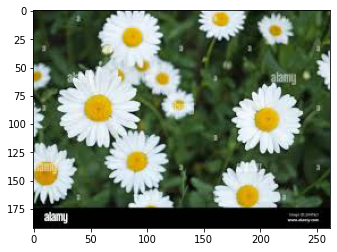

In [63]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Testing Data/Daisy/Daisy-Test (1).jpeg', 'r')


imshow(np.asarray(pil_im))

In [64]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/kaggle/input/refinado-flores/Flower Classification/Training Data'
validation_data_dir = '/kaggle/input/refinado-flores/Flower Classification/Validation Data'
test_data_dir = '/kaggle/input/refinado-flores/Flower Classification/Testing Data'
image_size = (150, 150)
batch_size = 16

In [65]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 5000 files belonging to 5 classes.
Found 2500 files belonging to 5 classes.
Found 951 files belonging to 5 classes.


# **Image Augmentation**

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        zoom_range=0.3
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds_augmentation = train_datagen.flow_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds_augmentation = train_datagen.flow_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 5000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 951 images belonging to 5 classes.


# **The Model**

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    

# MODEL --------------------------------------------------

##87%
model = Sequential()
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 128)     

In [82]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [83]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

history = model.fit_generator(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks= [es]
)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
311/313 [============================>.] - ETA: 0s - loss: 1.0769 - accuracy: 0.5613

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 1.0753 - accuracy: 0.5622 - val_loss: 0.7312 - val_accuracy: 0.7276
Epoch 2/200
312/313 [============================>.] - ETA: 0s - loss: 0.7852 - accuracy: 0.7119

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.7850 - accuracy: 0.7118 - val_loss: 0.6188 - val_accuracy: 0.7572
Epoch 3/200
312/313 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.7554

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.6733 - accuracy: 0.7558 - val_loss: 0.5923 - val_accuracy: 0.7816
Epoch 4/200
308/313 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.7729

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.6320 - accuracy: 0.7732 - val_loss: 0.5733 - val_accuracy: 0.8108
Epoch 5/200
310/313 [============================>.] - ETA: 0s - loss: 0.5564 - accuracy: 0.8000

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.5582 - accuracy: 0.7998 - val_loss: 0.5065 - val_accuracy: 0.8240
Epoch 6/200
313/313 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8146

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.5394 - accuracy: 0.8146 - val_loss: 0.4750 - val_accuracy: 0.8300
Epoch 7/200
312/313 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.8173

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.5102 - accuracy: 0.8174 - val_loss: 0.4903 - val_accuracy: 0.8200
Epoch 8/200
313/313 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8348

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.4588 - accuracy: 0.8348 - val_loss: 0.4289 - val_accuracy: 0.8504
Epoch 9/200
308/313 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8490

Cleanup called...


313/313 [==============================] - 10s 32ms/step - loss: 0.4313 - accuracy: 0.8484 - val_loss: 0.5140 - val_accuracy: 0.8228
Epoch 10/200
311/313 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8611

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.4126 - accuracy: 0.8614 - val_loss: 0.4397 - val_accuracy: 0.8492
Epoch 11/200
308/313 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.8598

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.4003 - accuracy: 0.8600 - val_loss: 0.4301 - val_accuracy: 0.8504
Epoch 12/200
308/313 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8782

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.3597 - accuracy: 0.8782 - val_loss: 0.3959 - val_accuracy: 0.8712
Epoch 13/200
313/313 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8810

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.3359 - accuracy: 0.8810 - val_loss: 0.4270 - val_accuracy: 0.8552
Epoch 14/200
313/313 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8814

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.3459 - accuracy: 0.8814 - val_loss: 0.4823 - val_accuracy: 0.8404
Epoch 15/200
312/313 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8998

Cleanup called...


313/313 [==============================] - 9s 30ms/step - loss: 0.3028 - accuracy: 0.8996 - val_loss: 0.5276 - val_accuracy: 0.8228
Epoch 16/200
313/313 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8974

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2842 - accuracy: 0.8974 - val_loss: 0.4358 - val_accuracy: 0.8628
Epoch 17/200
311/313 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9055

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2600 - accuracy: 0.9054 - val_loss: 0.5179 - val_accuracy: 0.8096
Epoch 18/200
311/313 [============================>.] - ETA: 0s - loss: 0.2659 - accuracy: 0.9055

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2650 - accuracy: 0.9060 - val_loss: 0.4085 - val_accuracy: 0.8796
Epoch 19/200
309/313 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9150

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.2459 - accuracy: 0.9150 - val_loss: 0.3963 - val_accuracy: 0.8728
Epoch 20/200
311/313 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9166

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2284 - accuracy: 0.9164 - val_loss: 0.4297 - val_accuracy: 0.8668
Epoch 21/200
311/313 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9208

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2347 - accuracy: 0.9202 - val_loss: 0.4053 - val_accuracy: 0.8644
Epoch 22/200
308/313 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9215

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2270 - accuracy: 0.9206 - val_loss: 0.4243 - val_accuracy: 0.8708
Epoch 23/200
312/313 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9205

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2354 - accuracy: 0.9204 - val_loss: 0.4265 - val_accuracy: 0.8656
Epoch 24/200
312/313 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9269

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.2220 - accuracy: 0.9268 - val_loss: 0.3668 - val_accuracy: 0.8896
Epoch 25/200
311/313 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9315

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.1996 - accuracy: 0.9316 - val_loss: 0.4291 - val_accuracy: 0.8760
Epoch 26/200
311/313 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9347

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.1854 - accuracy: 0.9346 - val_loss: 0.4004 - val_accuracy: 0.8828
Epoch 27/200
308/313 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9334

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.2072 - accuracy: 0.9334 - val_loss: 0.4903 - val_accuracy: 0.8656
Epoch 28/200
310/313 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9315

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.2037 - accuracy: 0.9318 - val_loss: 0.4020 - val_accuracy: 0.8828
Epoch 29/200
312/313 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9423

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1643 - accuracy: 0.9420 - val_loss: 0.4368 - val_accuracy: 0.8836
Epoch 30/200
311/313 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9423

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1726 - accuracy: 0.9420 - val_loss: 0.4445 - val_accuracy: 0.8812
Epoch 31/200
312/313 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9509

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1482 - accuracy: 0.9510 - val_loss: 0.4987 - val_accuracy: 0.8844
Epoch 32/200
309/313 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9476

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.1485 - accuracy: 0.9474 - val_loss: 0.4813 - val_accuracy: 0.8836
Epoch 33/200
309/313 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9474

Cleanup called...


313/313 [==============================] - 9s 30ms/step - loss: 0.1524 - accuracy: 0.9476 - val_loss: 0.4535 - val_accuracy: 0.8936
Epoch 34/200
309/313 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9448

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1789 - accuracy: 0.9448 - val_loss: 0.4701 - val_accuracy: 0.8888
Epoch 35/200
312/313 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9403

Cleanup called...


313/313 [==============================] - 9s 30ms/step - loss: 0.1775 - accuracy: 0.9404 - val_loss: 0.4501 - val_accuracy: 0.8804
Epoch 36/200
311/313 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9528

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1400 - accuracy: 0.9530 - val_loss: 0.5279 - val_accuracy: 0.8652
Epoch 37/200
308/313 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9552

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1419 - accuracy: 0.9548 - val_loss: 0.5244 - val_accuracy: 0.8788
Epoch 38/200
310/313 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9468

Cleanup called...


313/313 [==============================] - 10s 30ms/step - loss: 0.1569 - accuracy: 0.9468 - val_loss: 0.4837 - val_accuracy: 0.8800
Epoch 39/200
311/313 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.9530

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1431 - accuracy: 0.9522 - val_loss: 0.6217 - val_accuracy: 0.8560
Epoch 40/200
312/313 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9555

Cleanup called...


313/313 [==============================] - 8s 26ms/step - loss: 0.1274 - accuracy: 0.9552 - val_loss: 0.5401 - val_accuracy: 0.8848
Epoch 41/200
312/313 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9469

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1594 - accuracy: 0.9470 - val_loss: 0.4439 - val_accuracy: 0.8916
Epoch 42/200
311/313 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9558

Cleanup called...


313/313 [==============================] - 10s 30ms/step - loss: 0.1286 - accuracy: 0.9560 - val_loss: 0.4657 - val_accuracy: 0.8996
Epoch 43/200
311/313 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9528

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1387 - accuracy: 0.9528 - val_loss: 0.4889 - val_accuracy: 0.8884
Epoch 44/200
308/313 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9588

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1317 - accuracy: 0.9578 - val_loss: 0.6204 - val_accuracy: 0.8756
Epoch 45/200
308/313 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9655

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.1060 - accuracy: 0.9656 - val_loss: 0.5318 - val_accuracy: 0.8924
Epoch 46/200
312/313 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9545

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.1329 - accuracy: 0.9544 - val_loss: 0.5404 - val_accuracy: 0.8920
Epoch 47/200
311/313 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9624

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.1227 - accuracy: 0.9622 - val_loss: 0.6242 - val_accuracy: 0.8764
Epoch 48/200
313/313 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9552

Cleanup called...


313/313 [==============================] - 10s 30ms/step - loss: 0.1345 - accuracy: 0.9552 - val_loss: 0.5037 - val_accuracy: 0.8796
Epoch 49/200
312/313 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9621

Cleanup called...


313/313 [==============================] - 9s 27ms/step - loss: 0.1203 - accuracy: 0.9618 - val_loss: 0.5034 - val_accuracy: 0.8920
Epoch 50/200
309/313 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9500

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1608 - accuracy: 0.9498 - val_loss: 0.5147 - val_accuracy: 0.8784
Epoch 51/200
310/313 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9536

Cleanup called...


313/313 [==============================] - 9s 29ms/step - loss: 0.1398 - accuracy: 0.9534 - val_loss: 0.5480 - val_accuracy: 0.8888
Epoch 52/200
312/313 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9547

Cleanup called...


313/313 [==============================] - 9s 28ms/step - loss: 0.1350 - accuracy: 0.9548 - val_loss: 0.5612 - val_accuracy: 0.8888
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


In [85]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

Cleanup called...


              precision    recall  f1-score   support

           0     0.8979    0.8620    0.8796       500
           1     0.9271    0.9660    0.9461       500
           2     0.8140    0.8140    0.8140       500
           3     0.9260    0.9260    0.9260       500
           4     0.9319    0.9300    0.9309       500

    accuracy                         0.8996      2500
   macro avg     0.8994    0.8996    0.8993      2500
weighted avg     0.8994    0.8996    0.8993      2500



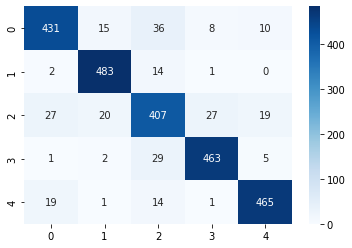

In [84]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

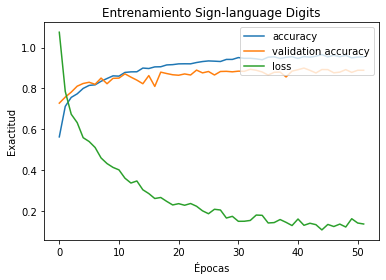

In [86]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Sign-language Digits')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
El vector de salida obtenido:  [[1.0258496e-21 9.3412317e-26 2.5430252e-13 1.0000000e+00 3.3940402e-34]]
La etiqueta de salida predicha es  3
Ahora dicho con texto: La etiqueta de salida predicha es  tres


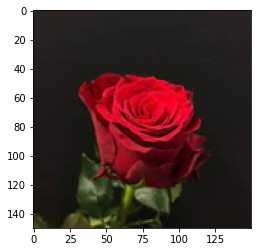

In [87]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']
%matplotlib inline

pil_im = Image.open('/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification/Flower Classification/Testing Data/Rose/rose (1).jpeg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






**Verificación de imagenes incompatibles**

In [74]:
from pathlib import Path
import imghdr

data_dir = "/kaggle/input/refinado-flores/Flower Classification/Testing Data"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [88]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Cero', 'Uno', 'Dos', 'Tres', 'Cuatro', 'Cinco', 'Seis', 'Siete', 'Ocho', 'Nueve']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL


Cleanup called...
Cleanup called...


Tres -> Tres
Tres -> Tres
Dos -> Dos
Cero -> Cero
Dos -> Cero ✘
Uno -> Dos ✘
Cuatro -> Cuatro
Dos -> Cero ✘
Cero -> Cero
Tres -> Tres
Cuatro -> Cero ✘
Dos -> Dos
Dos -> Dos
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Cero -> Dos ✘
Tres -> Tres
Cero -> Cero
Dos -> Dos
Tres -> Tres
Uno -> Uno
Uno -> Uno
Dos -> Dos
Dos -> Dos
Dos -> Dos
Cero -> Cero
Cuatro -> Cuatro
Cuatro -> Cero ✘
Dos -> Dos
Cero -> Cero
Cero -> Cero
Cero -> Cero
Uno -> Cero ✘
Cero -> Cero
Uno -> Dos ✘
Cero -> Cero
Dos -> Dos
Cero -> Cero
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Uno -> Uno
Dos -> Dos
Dos -> Cero ✘
Uno -> Cero ✘
Cuatro -> Cuatro
Cero -> Cero


Cleanup called...


Cuatro -> Cuatro
Tres -> Tres
Tres -> Tres
Cero -> Cero
Cero -> Cero
Cero -> Cero
Dos -> Cero ✘
Cuatro -> Cuatro
Dos -> Dos
Cero -> Cero
Cuatro -> Cuatro
Dos -> Dos
Tres -> Tres
Uno -> Uno
Cuatro -> Uno ✘
Uno -> Uno
Dos -> Dos
Cuatro -> Cuatro
Cuatro -> Cuatro
Cuatro -> Cuatro
Cuatro -> Cero ✘
Dos -> Dos
Uno -> Uno
Tres -> Tres
Uno -> Uno
Cuatro -> Cero ✘
Uno -> Uno
Cuatro -> Cuatro
Tres -> Tres
Tres -> Tres
Uno -> Dos ✘
Uno -> Uno
Cuatro -> Dos ✘
Dos -> Dos
Dos -> Dos
Cero -> Cuatro ✘
Tres -> Tres
Cero -> Dos ✘
Cuatro -> Cuatro
Dos -> Dos
Cero -> Cero
Cero -> Cero
Uno -> Uno
Cuatro -> Cuatro
Uno -> Uno
Dos -> Dos
Cuatro -> Cero ✘
Cero -> Cero
Dos -> Dos
Tres -> Tres
Dos -> Dos
Uno -> Uno
Uno -> Uno
Cuatro -> Cuatro
Tres -> Dos ✘
Dos -> Dos
Dos -> Dos
Dos -> Dos
Cero -> Cero
Uno -> Uno
Tres -> Tres
Cuatro -> Cuatro
Dos -> Dos
Cero -> Cero


Cleanup called...
Cleanup called...
Cleanup called...


Tres -> Dos ✘
Dos -> Dos
Dos -> Dos
Dos -> Dos
Dos -> Dos
Dos -> Dos
Dos -> Dos
Tres -> Tres
Dos -> Dos
Cero -> Cero
Tres -> Tres
Dos -> Dos
Uno -> Dos ✘
Cero -> Dos ✘
Cero -> Cero
Uno -> Uno
Cero -> Cero
Uno -> Uno
Cero -> Cero
Dos -> Cero ✘
Cuatro -> Cero ✘
Dos -> Dos
Cero -> Cero
Uno -> Uno
Dos -> Dos
Tres -> Dos ✘
Cero -> Cero
Uno -> Uno
Cuatro -> Cero ✘
Tres -> Tres
Cero -> Cero
Cero -> Cero
Dos -> Dos
Tres -> Tres
Cuatro -> Cuatro
Cuatro -> Cuatro
Cero -> Cero
Cero -> Cero
Dos -> Dos
Dos -> Dos
Cuatro -> Cero ✘
Cero -> Dos ✘
Uno -> Uno
Uno -> Dos ✘
Cuatro -> Dos ✘
Dos -> Dos
Cuatro -> Cuatro
Dos -> Dos
Cuatro -> Cuatro
Cuatro -> Cuatro
Dos -> Cero ✘
Uno -> Uno
Dos -> Dos
Dos -> Dos
Dos -> Dos
Cero -> Dos ✘
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cuatro -> Cero ✘
Tres -> Dos ✘
Uno -> Uno
Dos -> Dos
Dos -> Dos


Cleanup called...
Cleanup called...
Cleanup called...


Tres -> Tres
Cuatro -> Cuatro
Dos -> Dos
Dos -> Dos
Uno -> Uno
Dos -> Dos
Cuatro -> Cuatro
Cero -> Cero
Dos -> Dos
Cuatro -> Cuatro
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cuatro -> Dos ✘
Dos -> Dos
Dos -> Cero ✘
Cuatro -> Cuatro
Uno -> Uno
Dos -> Dos
Cero -> Cero
Dos -> Cero ✘
Cuatro -> Cuatro
Uno -> Uno
Dos -> Dos
Cero -> Dos ✘
Dos -> Dos
Uno -> Uno
Tres -> Tres
Uno -> Uno
Cero -> Cero
Cero -> Cero
Cuatro -> Cuatro
Cero -> Cero
Uno -> Uno
Dos -> Cero ✘
Dos -> Dos
Cero -> Cero
Cero -> Cero
Cuatro -> Cuatro
Uno -> Uno
Dos -> Dos
Cuatro -> Dos ✘
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cero -> Cero
Cuatro -> Cuatro
Dos -> Dos
Dos -> Dos
Dos -> Dos
Uno -> Uno
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Dos -> Dos
Uno -> Uno
Cuatro -> Cuatro
Dos -> Dos
Uno -> Uno
Tres -> Tres
Cero -> Cero
Cuatro -> Cuatro
Cero -> Uno ✘
Tres -> Tres
Cuatro -> Cuatro
Uno -> Uno
Cero -> Cero
Dos -> Dos
Dos -> Dos
Cero -> Cero
Dos -> Dos
Uno -> Uno
Tres -> Dos ✘
Tres -> Dos ✘
Dos -> Dos
Tres

Cleanup called...
Cleanup called...
Cleanup called...


Uno -> Uno
Dos -> Dos
Cuatro -> Cuatro
Cero -> Cero
Dos -> Dos
Cuatro -> Cuatro
Cuatro -> Cuatro
Cero -> Dos ✘
Dos -> Dos
Cuatro -> Cuatro
Cuatro -> Cuatro
Cero -> Cero
Cuatro -> Cero ✘
Uno -> Uno
Tres -> Dos ✘
Uno -> Uno
Dos -> Dos
Tres -> Tres
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Cero -> Dos ✘
Tres -> Tres
Tres -> Tres
Cero -> Cero
Uno -> Uno
Cuatro -> Cuatro
Dos -> Dos
Tres -> Tres
Cero -> Cero
Dos -> Dos
Cero -> Dos ✘
Cero -> Cero
Dos -> Dos
Uno -> Uno
Cero -> Cero
Cuatro -> Cuatro
Cuatro -> Cuatro
Dos -> Dos
Cero -> Cero
Cero -> Cero
Dos -> Dos
Cero -> Dos ✘
Tres -> Tres
Dos -> Dos
Dos -> Tres ✘
Dos -> Cero ✘
Dos -> Dos
Uno -> Uno
Cuatro -> Cero ✘
Cuatro -> Cuatro
Cero -> Cero
Cuatro -> Cuatro
Dos -> Dos
Dos -> Dos
Dos -> Dos
Tres -> Dos ✘
Dos -> Dos
Dos -> Uno ✘
Dos -> Dos
Uno -> Uno
Dos -> Dos
Cero -> Cero
Cero -> Cero


Cleanup called...
Cleanup called...


Uno -> Uno
Dos -> Dos
Cero -> Cero
Cuatro -> Dos ✘
Uno -> Uno
Cuatro -> Cuatro
Tres -> Tres
Cero -> Cero
Uno -> Uno
Uno -> Uno
Cero -> Dos ✘
Tres -> Tres
Cuatro -> Cuatro
Dos -> Dos
Dos -> Dos
Dos -> Dos
Dos -> Dos
Tres -> Tres
Cero -> Cero
Uno -> Uno
Cuatro -> Cuatro
Uno -> Uno
Cuatro -> Cuatro
Dos -> Dos
Cuatro -> Cuatro
Uno -> Uno
Cero -> Dos ✘
Cero -> Cero
Cero -> Cero
Cero -> Cero
Uno -> Uno
Cuatro -> Cuatro
Tres -> Tres
Dos -> Dos
Cuatro -> Cuatro
Cuatro -> Cuatro
Dos -> Dos
Cuatro -> Cero ✘
Cuatro -> Cuatro
Cuatro -> Cero ✘
Cuatro -> Cuatro
Cuatro -> Cero ✘
Dos -> Dos
Cero -> Cero
Uno -> Cero ✘
Dos -> Dos
Uno -> Dos ✘
Uno -> Uno
Tres -> Tres
Cero -> Cero
Cero -> Cero
Cuatro -> Cero ✘
Dos -> Dos
Dos -> Dos
Cero -> Cero
Cero -> Cero
Dos -> Dos
Cero -> Cero
Tres -> Dos ✘
Cuatro -> Cuatro
Cuatro -> Cero ✘
Dos -> Dos
Cero -> Cero
Dos -> Dos


Cleanup called...


Tres -> Dos ✘
Cuatro -> Cuatro
Cero -> Cero
Cuatro -> Cero ✘
Cuatro -> Cero ✘
Cuatro -> Cuatro
Cero -> Cero
Cero -> Cero
Dos -> Dos
Uno -> Uno
Cero -> Cero
Dos -> Dos
Uno -> Uno
Tres -> Dos ✘
Cero -> Cero
Tres -> Tres
Uno -> Uno
Dos -> Uno ✘
Cuatro -> Cuatro
Dos -> Dos
Cuatro -> Dos ✘
Dos -> Dos
Dos -> Dos
Uno -> Uno
Dos -> Dos
Uno -> Uno
Cuatro -> Cero ✘
Dos -> Dos
Dos -> Dos
Cero -> Dos ✘
Dos -> Dos
Cuatro -> Cuatro
Cero -> Cero
Tres -> Tres
Tres -> Tres
Cero -> Dos ✘
Cuatro -> Cuatro
Cero -> Cero
Dos -> Dos
Tres -> Tres
Tres -> Tres
Cero -> Cero
Dos -> Dos
Uno -> Uno
Cero -> Cero
Dos -> Dos
Dos -> Dos
Cero -> Dos ✘
Dos -> Dos
Cero -> Cero
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Cero -> Cero
Dos -> Dos
Uno -> Dos ✘
Uno -> Uno
Tres -> Tres
Cero -> Cero
Cero -> Cero
Dos -> Dos
Cuatro -> Cuatro
Dos -> Dos
Dos -> Dos
Uno -> Uno
Tres -> Dos ✘
Cero -> Cero
Cero -> Cero
Cuatro -> Cuatro
Dos -> Dos
Dos -> Tres ✘
Tres -> Tres
Uno -> Uno
Dos -> Dos
Dos -> Dos
Cuatro -> Cuatro
Tres -> Dos ✘
Uno 